<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/master/Medical_codesv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling medical codes using Python



Information about health events - diagnosis, prescriptions, procedures -   is often recorded using medical codes. For instance a patient with Crohn's disease may be recorded with the code _K50.0_ if the hospital uses the International Classification of Diseases version 10 (ICD-10). To analyse these data it is necessary to know that _K50.0_ means Crohn's Disease. It would also be useful to have tools that make it easier to use codes effectively. Some of the things we would like such a tool to do is:
- Translate from codes to text  (What does _K50_ mean?)
- Search for all codes that is used for a given disease (Find all codes that are used for or related to stroke) 
- Handle multiple coding systems with different versions, years, and languages
- Recode so analysis is possible when you have data that uses different coding systems (eg. from ICD 9 to 10 or from ICD to SNOMED)

In this notebook we will build such a tool. The starting point is the simplest possible solution: To use a dictionary. This solution is perfectly fine, but if you for those that deal with medical codes daily a more sophisticated tool is necessary - and we will build this too. But first; the easy solution!


# Starting example: Which diseases are most common?

The starting point is that we have data on all hospital events and we want to know what type of events that are most common. To do so we first count the frequency of the different codes. Next we create a dictionary to make it easier to see what diseases the different codes represent.

### Get necessary libraries and data

In [1]:
# Use pandas
import pandas as pd

In [2]:
# Read synthetic medicare sample data on inpatient hospital stays
path = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
inpatient_file = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip'

inpatient = pd.read_csv(path+inpatient_file)


## First look

In [3]:
inpatient.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,ADMTNG_ICD9_DGNS_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,HCPCS_CD_1,HCPCS_CD_2,HCPCS_CD_3,HCPCS_CD_4,...,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,20100312,4580,0.0,1100.0,0.0,0.0,1.0,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,NaN,20090412,7866,0.0,1068.0,0.0,0.0,6.0,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,NaN,20090831,6186,0.0,1068.0,0.0,0.0,2.0,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,6186,V5866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,1.119000e+09,20090917,29590,0.0,1068.0,0.0,0.0,3.0,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,NaN,20100626,5849,0.0,1100.0,0.0,0.0,5.0,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The column names are slightly cryptic, but if you want more information, it is available here: [Explanations from ResDac, HTML](https://www.resdac.org/cms-data/files/ip-encounter-final/data-documentation). Right now, the only thing we really need to know, is that the column _icd9_dgns_cd_1_ contains the first (of many) diagnoses connected to each event. We focus on this variable and use the method _value_counts()_ to count the number of times the different diagnoses are used:

#Common diseases

The aim is to examine how often different types of diagnosis are used. The column *icd9_dgns_cd_1* contains the first (of many) diagnoses connected to each event. We focus on this variable and use the method *value_counts()* to count the number of times the different diagnoses are used:


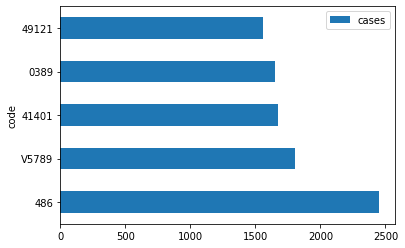

In [5]:
cases = inpatient['ICD9_DGNS_CD_1'].value_counts()
cases.index.name='code'
cases.name='cases'
cases.to_frame().head().plot.barh();

To interpret this result, it is necessary to know the name of the disease behind the codes, and it is very time consumping to look up each separately. What we need is an easy way to go from codes to a label.

One easy solution in Python is to use dictionaries, but first of all we need to find a file that has both the code and the text label. A good place to look for these is the National Bureau of Economic Research which maintain a collection of commonly used codebooks in the US:
  - Link to links: https://www.nber.org/data
  - Link to the specific codebook for ICD-9 (US version, 2010):  https://www.nber.org/data/ICD9ProviderDiagnosticCodes/2010/icd9dx2010.csv

### Read the codebook

In [6]:
icd9_codebook = pd.read_csv('https://www.nber.org/data/ICD9ProviderDiagnosticCodes/2010/icd9dx2010.csv')
icd9_codebook.head()


,dgns_cd,shortdesc,version,fyear
0,0010,Cholera d/t vib cholerae,27,2010
1,0011,Cholera d/t vib el tor,27,2010
2,0019,Cholera NOS,27,2010
3,0020,Typhoid fever,27,2010
4,0021,Paratyphoid fever a,27,2010


Note that the codes in the codebook include leading zeros, while the data in the other file may or may not use codes with (the same number of) leading zeros. To make it consistent, we might elminate leading zeros from both.

In [7]:
# Use .str.lstrip('0') to eliminate leading zeros in a column
icd9_codebook['dgns_cd']=icd9_codebook['dgns_cd'].str.lstrip('0')
inpatient['ICD9_DGNS_CD_1'] = inpatient['ICD9_DGNS_CD_1'].str.lstrip('0')

In [ ]:
icd9_code2text=dict(zip(icd9_codebook['dgns_cd'], icd9_codebook['shortdesc']))
icd9_code2text

Make a dictionary with codes and description only

In [ ]:
# to_dict
icd9_code2text=icd9_codebook.set_index('dgns_cd')['shortdesc'].to_dict()
icd9_code2text

In [16]:
# to_dict
icd9_code2text=icd9_codebook[['dgns_cd', 'shortdesc']].to_dict()
icd9_code2text

{0: {'dgns_cd': '10', 'shortdesc': 'Cholera d/t vib cholerae'},
 1: {'dgns_cd': '11', 'shortdesc': 'Cholera d/t vib el tor'},
 2: {'dgns_cd': '19', 'shortdesc': 'Cholera NOS'},
 3: {'dgns_cd': '20', 'shortdesc': 'Typhoid fever'},
 4: {'dgns_cd': '21', 'shortdesc': 'Paratyphoid fever a'},
 5: {'dgns_cd': '22', 'shortdesc': 'Paratyphoid fever b'},
 6: {'dgns_cd': '23', 'shortdesc': 'Paratyphoid fever c'},
 7: {'dgns_cd': '29', 'shortdesc': 'Paratyphoid fever NOS'},
 8: {'dgns_cd': '30', 'shortdesc': 'Salmonella enteritis'},
 9: {'dgns_cd': '31', 'shortdesc': 'Salmonella septicemia'},
 10: {'dgns_cd': '320', 'shortdesc': 'Local salmonella inf NOS'},
 11: {'dgns_cd': '321', 'shortdesc': 'Salmonella meningitis'},
 12: {'dgns_cd': '322', 'shortdesc': 'Salmonella pneumonia'},
 13: {'dgns_cd': '323', 'shortdesc': 'Salmonella arthritis'},
 14: {'dgns_cd': '324', 'shortdesc': 'Salmonella osteomyelitis'},
 15: {'dgns_cd': '329', 'shortdesc': 'Local salmonella inf NEC'},
 16: {'dgns_cd': '38', 'sh

To translate the codes to text, we use the method *rename*. The codes, in this case, are in the index, so we use the dictionary (*icd9_code2text*) to rename the index column.

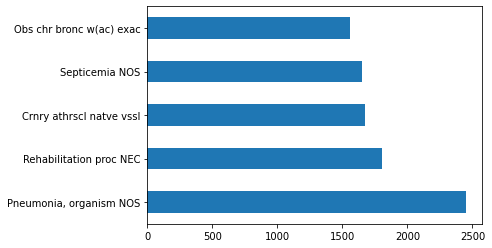

In [ ]:

(inpatient['ICD9_DGNS_CD_1']
    .value_counts()
    .rename(index=icd9_code2text)
    .head()
    .plot.barh());

## How to convert between ICD 9 and 10?

Medical coding systems change, and if you have two files with different versions of the coding system, you have to convert one of them in order to make the coding consisten across the file you want to analyze. For instance, the US has switched to the ICD 10 system, but many researchers have data with ICD 9 codes. The ICD 10 has many more detailed diagnoses than ICD 9. If you have both type of files, you may want to either change the one with ICD 10 to ICD 9, or try to transform the ICD 9 to ICD 10. The NBER have provided files for both cases and different types of codes (procedures and clinical). More here: https://www.nber.org/gem/icd10cmtoicd9gem.csv

As an example, let's try to transform the ICD 9 codes to ICD 10. 

First we read the conversion codebook:

In [ ]:

icd9to10 = pd.read_csv('https://www.nber.org/gem/icd9toicd10cmgem.csv')
icd9to10.head()

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,0010,A000,0,0,0,0,0,0
1,0011,A001,0,0,0,0,0,0
2,0019,A009,0,0,0,0,0,0
3,0020,A0100,10000,1,0,0,0,0
4,0021,A011,0,0,0,0,0,0


Next we create a dictionary mapping ICD 9 to ICD 10 codes:

In [ ]:
icd_map_9to10 = dict(zip(icd9to10.icd9cm, icd9to10.icd10cm))
icd_map_9to10

Make a new column mapping the old to new ICD codes:

In [ ]:
inpatient['icd10']=inpatient['ICD9_DGNS_CD_1'].map(icd_map_9to10)
inpatient['icd10']


0            R55
1          C7800
2           N815
3           F322
4           G609
          ...   
66768       J111
66769    T424X4A
66770      C7952
66771       C169
66772      I2510
Name: icd10, Length: 66773, dtype: object

Having converted the codes to ICD 10, we now need the codebook for ICD 10 to know what the new codes mean:

In [ ]:

icd10_codebook = pd.read_table('ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/ICD10CM/2019/icd10cm_codes_2019.txt', 
                            header=None, names = ['icd10_code', 'icd10_text'], sep='   ')
icd10_codebook

/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:755: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


,icd10_code,icd10_text
0,A000,"Cholera due to Vibrio cholerae 01, biovar cho..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,A009,"Cholera, unspecified"
3,A0100,"Typhoid fever, unspecified"
4,A0101,Typhoid meningitis
...,...,...
71927,Z9912,Encounter for respirator [ventilator] dependen...
71928,Z992,Dependence on renal dialysis
71929,Z993,Dependence on wheelchair
71930,Z9981,Dependence on supplemental oxygen


And we should get the same result, with new codes:

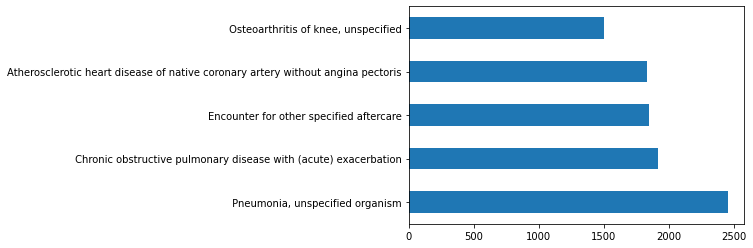

In [ ]:
icd10_codes2text=icd10_codebook.set_index('icd10_code').icd10_text.to_dict()
inpatient.icd10.value_counts().rename(index=icd10_codes2text).head().plot.barh();

## Changing the granularity of a a code

Overviews at the level of full ICD categories are often too detailed to be useful. For instance, there are meny differnt ICD 10 categories for births, and in order to know how many births there were, we have to group all of these codes into larger categories before counting.

First, as a starting point to find relevant categories, we search for "birth" in the codebook:

In [ ]:
icd10_codebook.query("'birth' in icd10_text")

,icd10_code,icd10_text


In [ ]:
icd10_codebook = icd10_codebook.set_index('icd10_code')
birth_rows=icd10_codebook.icd10_text.str.contains('birth', na=False)
icd10_codebook[birth_rows]

,icd10_text
icd10_code,
N643,Galactorrhea not associated with childbirth
O1002,Pre-existing essential hypertension complicati...
O1012,Pre-existing hypertensive heart disease compli...
O1022,Pre-existing hypertensive chronic kidney disea...
O1032,Pre-existing hypertensive heart and chronic ki...
...,...
Z382,"Single liveborn infant, unspecified as to pla..."
Z385,"Twin liveborn infant, unspecified as to place..."
Z388,"Other multiple liveborn infant, unspecified a..."


Clearly not all of these codes are relevant if we want to make a list of codes related to childbirth. The first, N643, is explicitly *not* about childbirth. But some codes look very relevant, for instance the codes starting with Z38 seem to be important.

To look closere at the Z38 codes we use _startswith()_:



In [ ]:
icd10_codebook[icd10_codebook.index.str.startswith('Z38')]

,icd10_text
icd10_code,
Z3800,"Single liveborn infant, delivered vaginally"
Z3801,"Single liveborn infant, delivered by cesarean"
Z381,"Single liveborn infant, born outside hospital"
Z382,"Single liveborn infant, unspecified as to pla..."
Z3830,"Twin liveborn infant, delivered vaginally"
Z3831,"Twin liveborn infant, delivered by cesarean"
Z384,"Twin liveborn infant, born outside hospital"
Z385,"Twin liveborn infant, unspecified as to place..."
Z3861,"Triplet liveborn infant, delivered vaginally"


To count codes at a higher level than the most detailed ICD 10 category, we could try to count the number of different codes when we only use the  first three character of the full ICD 10 code:

In [ ]:
# Use .str()[:3] to slice the first three charcters of all elements in a series
inpatient.icd10.str[:3].value_counts()

I50    3143
J18    2558
J44    2397
I25    1994
Z51    1986
       ... 
E55       1
H57       1
C62       1
O80       1
F84       1
Name: icd10, Length: 825, dtype: int64

This works, but unfortunately, the file we used from the NBER to create a mapping between text and code, only included the detailed codes and not the text mapping for the more general codes. 

Exercise: Map the ICD 10 categories to the US system of Hierarchical Condition Categories (HCC) using these files:
https://www.nber.org/data/icd-hcc-crosswalk-icd-rxhcc-crosswalk.html


# Another example: National Drug Codes

National Drug Codes are used in the US to record the different types of pharmaceuticals a patient gets. It is more complicated than the example with the ICD because in order to use these codes, we often have to extracts and reconstruct parts of the code. This is because the code itself has three parts (the labeller, the product, and the package), and there are two different standards (some use NDC codes that are 11 digits, some use 10 digits), and there are different practices with respect to whether a leading zero should be included. More details in this link: https://www.drugs.com/ndc.html

But, instead of being caught up in all the problems, let us just dive in and solve the issues as they appear!

We will start by loading a sample of synthetic data on prescription events from medicare:

In [ ]:
# imports
import pandas as pd

In [ ]:
# Read synthetic medicare sample data on pharmaceuticals
path= 'http://downloads.cms.gov/files/'
rx_file = 'DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_1.zip'
#path = 'http://downloads.cms.gov/files/'
rx = pd.read_csv(path+rx_file)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# First look
rx.head()

,DESYNPUF_ID,PDE_ID,SRVC_DT,PROD_SRVC_ID,QTY_DSPNSD_NUM,DAYS_SUPLY_NUM,PTNT_PAY_AMT,TOT_RX_CST_AMT
0,00013D2EFD8E45D1,233664490397622,20080103,247037252,30.0,20,10.0,120.0
1,00013D2EFD8E45D1,233644490171972,20080105,223039502,10.0,10,0.0,0.0
2,00013D2EFD8E45D1,233974489116848,20080109,364724812,120.0,30,10.0,110.0
3,00013D2EFD8E45D1,233574491083209,20080123,179180672,30.0,30,0.0,240.0
4,00013D2EFD8E45D1,233024491180571,20080124,58016005300,30.0,30,70.0,70.0


In [ ]:
# Initial preparation

rx.columns=rx.columns.str.lower()
rx['pid']=rx.desynpuf_id
rx=rx.set_index('pid', drop=False)
rx.index.name='pid_index'

# Which type of pharmaceutical is most commonly prescribed?

Information about the pharmaceutical, is in the *prod_srvc_id colum*, so we select that column from the *rx* dataframe and do a value_counts() with the argument *normalize=True* in order to get the percentage instead of the absolute number of events with the phamrmaceutical.

In [ ]:
rx.prod_srvc_id.value_counts()


2840001        165
54868540600    156
62381840001    142
52959081303    141
54569489700    140
              ... 
67544002570      1
00093014810      1
00879015010      1
51079009501      1
52945002301      1
Name: prod_srvc_id, Length: 507625, dtype: int64

In order to interpret this we would like to know the name of the products, not just the product code. So we need to get the codebook for drug products. NBER has these codebooks, one for products and one for packages, and we download these.

In [ ]:
# Read codebooks for NDC codes
ndc_product_codes = pd.read_csv('https://www.nber.org/fda/ndc/product.csv', encoding='latin-1')
ndc_product_codes.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,prodid,ndc,prodtype,propname,propsuf,npropname,dosename,routename,stmarkdatestr,stmarkdate,endmarkdatestr,endmarkdate,markname,appnum,labelname,subname,actnumstr,actingunit,pharmclas,deasched,ndc_exclude_flag,listing_record_certstr,listing_record_cert
0,0002-1200_4bd46cbe-cdc1-4329-a8e7-22816bd7fc33,0002-1200,HUMAN PRESCRIPTION DRUG,Amyvid,NaN,Florbetapir F 18,"INJECTION, SOLUTION",INTRAVENOUS,20120601,6/1/2012,.,NaN,NDA,NDA202008,Eli Lilly and Company,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",NaN,N,20181231,12/31/2018
1,0002-1407_14757f9d-f641-4836-acf3-229265588d1d,0002-1407,HUMAN PRESCRIPTION DRUG,Quinidine Gluconate,NaN,Quinidine Gluconate,SOLUTION,INTRAVENOUS,19500712,7/12/1950,.,NaN,NDA,NDA007529,Eli Lilly and Company,QUINIDINE GLUCONATE,80,mg/mL,"Antiarrhythmic [EPC],Cytochrome P450 2D6 Inhib...",NaN,N,20181231,12/31/2018
2,0002-1433_b39d3d3d-6b7c-40c2-becb-953830f47f3f,0002-1433,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20141107,11/7/2014,.,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20181231,12/31/2018
3,0002-1434_b39d3d3d-6b7c-40c2-becb-953830f47f3f,0002-1434,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20141107,11/7/2014,.,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20181231,12/31/2018
4,0002-1445_5253637b-af17-41b5-84dd-e7fd5e7cf54b,0002-1445,HUMAN PRESCRIPTION DRUG,TALTZ,NaN,ixekizumab,"INJECTION, SOLUTION",SUBCUTANEOUS,20160322,3/22/2016,.,NaN,BLA,BLA125521,Eli Lilly and Company,IXEKIZUMAB,80,mg/mL,"Interleukin-17A Antagonist [EPC],Interleukin-1...",NaN,N,20191231,12/31/2019


When we compare the NDC codes in the prescription file (rx.prod_srvc_id) and the NDC codes in the codebook, we realize that we have to do some transformations for mapping to work. The rx file has an NDC code of mainly - but not always - 11 digits stored as an integer, while the codefile has the first two parts of the code separated by a hyphen.

Since we are mainly concerned with the product type, and not how it is packaged, it is OK to focus on the first nine digits of the 11 digit code. However, we need to make sure that we include the leading zeros, so it has to be formatted as a string with 11 digits (filling up with zeros if necessary) and from this we can extract the first nine. We can label this new column *ndc9*, and to create it in the rx file, we:

In [ ]:
#rx['ndc9'] = rx.prod_srvc_id.str.zfill(11).str[:9]

rx['ndc9'] = rx.prod_srvc_id.astype(str).str.zfill(11).str[:9]
rx['ndc9'].head()

pid_index
00013D2EFD8E45D1    002470372
00013D2EFD8E45D1    002230395
00013D2EFD8E45D1    003647248
00013D2EFD8E45D1    001791806
00013D2EFD8E45D1    580160053
Name: ndc9, dtype: object

rx['ndc9'].str.len().value_counts()

In [ ]:
rx['ndc9'].str.len().value_counts()

9    5552421
Name: ndc9, dtype: int64

In [ ]:
ndcinrx = set(rx['ndc9'])

In [ ]:
len(ndcinrx)

117651

Ooooops! We did it again! There is still a problem and a major gotcha. The problem is the following: the *prod_srvc_id* colum in the rx file is of mixed datatypes. Some cells as integers, some are strings. For cells that are integers, the return value is missing when we apply the string opertions we tried. Hence, before we apply the string operations, we need to make sure that the column is a string - and noting but a string. (A small problem in the Pyton/Pandas/numpy datatype system is that the dtype 'object' is both a string and mixed dtypes)

The datatype was inferred automatically when Pandas read the data, and it underlines how important it is to make sure to fix datatypes before doing analysis - and how vulnerable .csv files are since they do not store information about datatypes (It has to ne infered each time it is read).

So, to make a lon gotach end, we have to add *astype(str)* to our chain:



In [ ]:
#rx['ndc9'] = rx.prod_srvc_id.astype(str).str.strip().str.zfill(11).str[:9]
rx['ndc9'] = pd.to_numeric(rx['prod_srvc_id'], errors='coerce').astype('Int64').astype(str).str.strip().str.zfill(11).str[:9]
rx['ndc9'].head()

pid_index
00013D2EFD8E45D1    002470372
00013D2EFD8E45D1    002230395
00013D2EFD8E45D1    003647248
00013D2EFD8E45D1    001791806
00013D2EFD8E45D1    580160053
Name: ndc9, dtype: object

Next we need to format the codebook so was have an NDC code that has the same format: 9 digits with leading zeros. We do this by splitting on the hypen and making sure that the first element has five digits (filling up with leading zeros if necessary) and the last part should have four digits (once again filling up with leading zeros if necessary):



In [ ]:
labeler = ndc_product_codes.ndc.str.split('-').str[0].str.zfill(5)
product = ndc_product_codes.ndc.str.split('-').str[1].str.zfill(4)
ndc_product_codes['ndc9']=labeler + product

# Pharmaceuticals have non-proprietary and proprietary names. 
# Here we use the nonproprietory names in the dictionary
ndc2text = ndc_product_codes.set_index('ndc9').npropname.to_dict()

We now have a column in the prescription file (*ndc9*) for which we have a codebook and a dictionary that can map the code to text. Let's try, as before:

In [ ]:
rx.ndc9.value_counts().rename(index=ndc2text)

580160892                  8104
580160777                  7965
580160606                  7506
580160252                  7337
580160425                  7304
                           ... 
000741582                     1
495020820                     1
000680205                     1
Lopinavir and Ritonavir       1
497880256                     1
Name: ndc9, Length: 117651, dtype: int64

Hmm, something looks wrong. There are two problems here. First, we transformed the codes to text *after* doing the counting. This creates a problem in this context because two different codes can refer to the same generic product. For instance, 08453453 could be pharmaceutical X, and 08453445 could also be pharmaceutical X. When we count the codes first, before changing the names, we will get a separate row for each code, and when we rename the codes to text these rows will stay separate. If we want to aggregate everything that has the same text, we have to tell Pandas to do this:

In [ ]:
rx.ndc9.value_counts().rename(index=ndc2text).sum(level=0).sort_values(ascending=False)

Oxygen         25529
Simvastatin    22674
Lisinopril     14975
Lovastatin     14359
OXYGEN         11719
               ...  
546990015          1
003498426          1
425070441          1
002645808          1
497880256          1
Name: ndc9, Length: 101150, dtype: int64

This shows that we manage to get the names of the major pharmaceuticals, but it also showed a very subtle problem that could easily be overlooked. In fact, there are more problems here (for instance, upper and lower case names should be the same pharmaceutical), and as long as there is not a memory problem, it seems better to simply include a column in the rx file with the names and count these. Like this:

In [ ]:
rx['pharma_name']=rx.ndc9.map(ndc2text).str.capitalize().astype('category')

Unpacking the code: We create a new column (*name*), by mapping the ndc9 number to its text. Then we make the case consistent (capitalized first letter only), and we use a datatype called category which means that internally each name gets a number, so we do not have to store a long text for each cell.

In [ ]:
rx['pharma_name'].value_counts()

Simvastatin                                               37884
Oxygen                                                    37713
Lisinopril                                                20832
Metformin hydrochloride                                   18944
Lovastatin                                                18706
                                                          ...  
Fexofenadine and pseudoephedrine                              1
Polyethylene glycol 400 and propylene glycol                  1
Dextromethorphan hydrobromide chlorpheniramine maleate        1
Polyethylene glycol and propylene glycol                      1
Ammonia inhalants                                             1
Name: pharma_name, Length: 2964, dtype: int64

This looks  better. At his point one might convert it to percentages too - sometthing it is often useful not to do while checking if tings work since we need to see absolute number to evaluate whether the code did what it was supposed to do.





Exercise

The mapping of codes to text look much better in the last iteration, but there is still some cleaning that could be done. For instance, it seems  the non-proprietary names in the codebook sometimes include long names that are not standardized. One should also at least check how many codes that do not have a mapping to a text description. 

In [ ]:
rx.pharma_name.isnull().sum()/len(rx)


0.7962146602355982

In [ ]:
len(ndc2text)

119083

In [ ]:
len(rx.ndc9.unique())

117651

In [ ]:
ndcincb=set(ndc2text.keys())

In [ ]:
len(ndcincb & ndcinrx)

20524

In [ ]:
no_name = rx.pharma_name.isnull()

In [ ]:
rx.loc[no_name, ['prod_srvc_id', 'pharma_name', 'ndc9']]

,prod_srvc_id,pharma_name,ndc9
pid_index,,,
00013D2EFD8E45D1,247037252,NaN,002470372
00013D2EFD8E45D1,223039502,NaN,002230395
00013D2EFD8E45D1,364724812,NaN,003647248
00013D2EFD8E45D1,179180672,NaN,001791806
00013D2EFD8E45D1,58016005300,NaN,580160053
...,...,...,...
FFFF7C107A4E385A,51316006301,NaN,513160063
FFFF7C107A4E385A,58016038477,NaN,580160384
FFFF7C107A4E385A,52446003528,NaN,524460035


In [ ]:
ndc_product_codes[ndc_product_codes.ndc.str.startswith('6238')]

,prodid,ndc,prodtype,propname,propsuf,npropname,dosename,routename,stmarkdatestr,stmarkdate,endmarkdatestr,endmarkdate,markname,appnum,labelname,subname,actnumstr,actingunit,pharmclas,deasched,ndc_exclude_flag,listing_record_certstr,listing_record_cert,ndc9
83650,62382-0308_0685b7dd-995c-5175-e054-00144ff8d46c,62382-0308,HUMAN OTC DRUG,Easy to break-off cleaning and disinfecting sw...,NaN,Alcohol swabstick,SWAB,TOPICAL,20140401,4/1/2014,.,NaN,OTC MONOGRAPH NOT FINAL,part333A,"Longood Medicine (Beijing) Co., Ltd.",ALCOHOL,.7,mL/mL,NaN,NaN,E,20171231,12/31/2017,623820308
83651,62382-0315_957329b1-17ac-49d4-b01c-3d39815a9c6d,62382-0315,HUMAN OTC DRUG,Easy to break-off cleaning and disinfecting sw...,NaN,Isopropyl alcohol swabstick,SWAB,TOPICAL,20140401,4/1/2014,.,NaN,OTC MONOGRAPH NOT FINAL,part333A,"Longood Medicine (Beijing) Co., Ltd.",ISOPROPYL ALCOHOL,.7,mL/mL,NaN,NaN,E,20171231,12/31/2017,623820315
83652,62382-0322_f335c19a-4871-40e5-9e38-bf084b68eb5a,62382-0322,HUMAN OTC DRUG,Easy to break-off cleaning and disinfecting sw...,NaN,Povidone iodine swabstick,SWAB,TOPICAL,20140328,3/28/2014,.,NaN,OTC MONOGRAPH NOT FINAL,part333A,"Longood Medicine (Beijing) Co., Ltd.",POVIDONE-IODINE,.1,mg/mL,NaN,NaN,E,20171231,12/31/2017,623820322
83653,62382-0323_11205be3-1a69-4a69-ac14-a18e8fe7ffac,62382-0323,HUMAN OTC DRUG,Easy to break-off cleaning and disinfecting sw...,NaN,Isopropyl Alcohol,SWAB,TOPICAL,20150328,3/28/2015,.,NaN,OTC MONOGRAPH NOT FINAL,part333A,"Longood Medicine (Beijing) Co., Ltd.",ISOPROPYL ALCOHOL,.7,mL/mL,NaN,NaN,E,20171231,12/31/2017,623820323
83654,62382-0324_8c1ab116-be30-43f0-8a71-ff2dcc451946,62382-0324,HUMAN OTC DRUG,CHG,NaN,Isopropyl Alcohol,SWAB,TOPICAL,20150828,8/28/2015,.,NaN,OTC MONOGRAPH NOT FINAL,part333A,"Longood Medicine (Beijing) Co., Ltd.",ISOPROPYL ALCOHOL,.7,mL/mL,NaN,NaN,E,20171231,12/31/2017,623820324


In [ ]:
rx[no_name]['prod_srvc_id'].value_counts().head(25)

54868540600    156
62381840001    142
52959081303    141
54569489700    140
490020503      139
37024110       137
58016060618    136
64378033202    136
62381897101    135
60312096001    134
2897101        133
58016077792    133
58016060650    133
61947015803    131
57664011583    130
58016089232    130
66267056520    130
24658021010    129
54569562500    129
55154342502    129
247219630      129
58016060632    129
58016060675    128
17088006601    128
54868548900    128
Name: prod_srvc_id, dtype: int64

In [ ]:
rx['prod_srvc_id'].astype(str).str.len().value_counts()

11    4231919
9      991251
8      242384
7       80774
10       6070
5          23
Name: prod_srvc_id, dtype: int64

In [ ]:
len(rx)

5552421

In [ ]:
pd.to_numeric(rx['prod_srvc_id'], errors='coerce').astype('Int64').astype(str).str.strip().str.zfill(11).str[:9]

pid_index
00013D2EFD8E45D1    002470372
00013D2EFD8E45D1    002230395
00013D2EFD8E45D1    003647248
00013D2EFD8E45D1    001791806
00013D2EFD8E45D1    580160053
                      ...    
FFFF7C107A4E385A    513160063
FFFF7C107A4E385A    580160384
FFFF7C107A4E385A    524460035
FFFF7C107A4E385A    551546217
FFFF7C107A4E385A    496480133
Name: prod_srvc_id, Length: 5552421, dtype: object

In [ ]:
def expand_codes(df=None,
                 codes=None,
                 cols=None,
                 sep=None,
                 codebook=None,
                 hyphen=True,
                 star=True,
                 colon=True,
                 regex=None,
                 del_dot=False,
                 case_sensitive=True,
                 exist=True,
                 merge=False,
                 group=False):
    """
    Expand list of codes with star, hyphen and colon notation to full codes
    Args:
        codes (str or list of str): a list of codes some of which may need to be expanded to full codes
        cols (str): a column with codes that are be used to build a codebook of all codes
            If codebook is specified the cols argument is not needed and ignored
        sep (str): seperator used if cells have multiple values
        codebook (list): User specified list of all possible or allowed codes
        expand_hyphen (bool, default: False): If True, codes with hyphens are not expanded
        expand_star (bool, default: False): If True, codes with start are not expanded
    Returns
        List of codes
    Examples
        >>> codes = expand_codes(df=df, codes=['H02*'], cols='atc')
        >>> codes = expand_codes(df=df, codes=['K25*'], cols='icdmain', sep=',', codebook=codebook)
        >>> codes = expand_codes(df=df, codes=['K25*-K28*'], cols='icdmain', sep=',', codebook=codebook, merge=True)
        >>> codes = expand_codes(df=df, codes=['K50*', 'K51*'], cols='icdmain', sep=',', codebook=codebook, merge=False, group=True)
        >>> codes = expand_codes(df=df, codes=['K50*', 'K51*'], cols='icdmain', sep=',', codebook=codebook, merge=False, group=False)
        >>> ulcer = ['K25*-K28*']
        >>> liver = 'B18* K70.0-K70.3 K70.9 K71.3-K71.5 K71.7 K73* K74* K76.0 K76.2-K76.4 K76.8 K76.9 Z94.4'.split()
        >>> diabetes =	['E10.0', 'E10.l', 'E10.6', 'E10.8', 'E10.9', 'E11.0', 'E11.1', 'E11.6', 'E11.8', 'E11.9', 'E12.0', 'E12.1', 'El2.6', 'E12.8', 'El2.9', 'E13.0', 'E13.1', 'E13.6', 'E13.8', 'E13.9', 'E14.0', 'E14.1', 'E14.6', 'E14.8', 'E14.9']
        >>> hemiplegia = ['G04.1', 'G11.4', 'G80.1', 'G80.2', 'G81*', 'G82*', 'G83.0-G83.4', 'G83.9']
        >>> expand_codes(df=df, codes=ulcer, cols='icdmain', sep=',')
    Note:
        Only codes that actually exist in the cols or the codebook are returned
    """

    codes = _listify(codes)

    if codebook:
        unique_words = set(codebook)
    else:
        cols = _listify(cols)
        cols = _expand_cols(df=df, cols=cols)
        unique_words = set(unique_codes(df=df, cols=cols, sep=sep))

    # if input is not a list of codes, but a dict with categories and codes,
    # then expand each category separately and return the whole dict with
    # expanded codes

    if isinstance(codes, list):
        alist = True
    else:
        alist = False

    codes = _format_codes(codes=codes, merge=merge)

    all_new_codes = {}

    for name, codelist in codes.items():

        # for instance in icd-10 some use codes with dots, some without
        if del_dot:
            # unique_words = {word.replace('.', '') for word in unique_words}
            codelist = [code.replace('.', '') for code in codelist]

        if not case_sensitive:
            # unique_words = {word.lower() for word in unique_words}
            codelist = [code.lower() for code in codelist] + [code.upper() for code in codelist]

        # expand hyphens codes but keep only those that are in the cols or the codebook
        if hyphen:
            codelist = expand_hyphen(codelist)

        # expand only codes with star notation and when expand_stars is turned on
        if star:
            codelist = expand_star(codelist, full_list=unique_words)

        # regex can be used, but may be complex if combined with other
        # maybe introduce a notation for regex inside the codebook?, like re:
        # (so the regex is not done on all codes)
        if regex:
            codelist = _expand_regex(codelist, full_list=unique_words)

        # eliminate codes that have been created by the expansion, but that do not
        # exist in the data. For instance, the hyphen expansion may create this.
        if exist:
            match = set(codelist) & unique_words
            codelist = list(match)

        all_new_codes[name] = codelist

        # Change dictionary depending on whether the user wants codes with
        # special notations (star, hyphen, colon, eg. K51* to stay as a
        # separate group or be split in its individual subcodes

    if (not group) and (not merge):
        new_all_new_codes = {}
        for name, codelist in all_new_codes.items():
            if ('*' in name) or ('-' in name) or (':' in name):
                for code in codelist:
                    new_all_new_codes[code] = [code]
            else:
                new_all_new_codes[name] = codelist
        all_new_codes = new_all_new_codes

    if merge:
        pass
        # all_new_codes=list(all_new_codes.values())[0]

    return all_new_codes



In [ ]:
def _listify(string_or_list):
    """
    return a list if the input is a string, if not: returns the input as it was
    Args:
        string_or_list (str or any):
    Returns:
        A list if the input is a string, if not: returns the input as it was
    Note:
        - allows user to use a string as an argument instead of single lists
        - cols='icd10' is allowed instead of cols=['icd10']
        - cols='icd10' is transformed to cols=['icd10'] by this function
    """
    if isinstance(string_or_list, str):
        string_or_list = [string_or_list]
    return string_or_list


def expand_cols(df, cols, star=True, hyphen=True, colon=True, regex=None):
    """
    Expand columns with special notation to their full column names
    """

    cols = _listify(cols)

    allcols = list(df.columns)

    if hyphen:
        cols = expand_hyphen(expr=cols)
    if star:
        cols = expand_star(expr=cols, full_list=allcols)
    if colon:
        cols = expand_colon(expr=cols, full_list=allcols)
    if regex:
        cols = list(df.columns(df.columns.str.contains(regex)))

    return cols


def expand_colon(expr, full_list):
    """
    Expand expressions with colon notation to a list of complete columns names
    expr (str or list): Expression (or list of expressions) to be expanded
    full_list (list or array) : The list to slice from
    """
    exprs = _listify(expr)
    expanded = []

    for expr in exprs:
        if ':' in expr:
            startstr, endstr = expr.split(':')
            startpos = full_list.index(startstr)
            endpos = full_list.index(endstr) + 1
            my_slice = full_list[startpos:endpos]
        else:
            my_slice = [expr]

        expanded.extend(my_slice)
    return expanded


def expand_star(expr, cols=None, full_list=None, sep=None):
    """
    Expand expressions with star notation to all matching expressions
    """

    exprs = _listify(expr)

    if isinstance(full_list, pd.Series):
        pass
    elif isinstance(full_list, list):
        unique_series = pd.Series(full_list)
    elif isinstance(full_list, set):
        unique_series = pd.Series(list(full_list))
    else:
        unique = unique_codes(df=df, cols=cols, sep=sep)
        unique_series = pd.Series(list(unique))

    expanded = []

    for expr in exprs:
        if '*' in expr:
            startstr, endstr = expr.split('*')
            if startstr:
                add_expr = list(unique_series[unique_series.str.startswith(startstr)])
            if endstr:
                add_expr = list(unique_series[unique_series.str.endswith(endstr)])
            if startstr and endstr:
                # col with single letter not included, start means one or more of something
                # beginning is not also end (here!)
                start_and_end = (unique_series.str.startswith(startstr)
                                 &
                                 unique_series.str.endswith(endstr))
                add_expr = list(unique_series[start_and_end])
        else:
            add_expr = [expr]

        expanded.extend(add_expr)
    return expanded


def expand_hyphen(expr):
    """
    Example: Expands ('b01A-b04A') to ['b01A' ,'b02A', 'b03A', 'b04A']
    Args:
        code
    Returns:
        List
    Examples:
        expand_hyphen('b01.1*-b09.9*')
        expand_hyphen('n02.2-n02.7')
        expand_hyphen('c00*-c260')
        expand_hyphen('b01-b09')
        expand_hyphen('b001.1*-b009.9*')
        expand_hyphen(['b001.1*-b009.9*', 'c11-c15'])
    Note:
        decimal expression also works: expr = 'n02.2-n02.7'
        expr = 'b01*-b09*'
        expr = 'C00*-C26*'
    """

    exprs = _listify(expr)
    all_codes = []

    for expr in exprs:
        if '-' in expr:
            lower, upper = expr.split('-')
            lower_str = re.search("[-+]?\d*\.\d+|\d+", lower).group()
            upper_str = re.search("[-+]?\d*\.\d+|\d+", upper).group()

            lower_num = float(lower_str)
            upper_num = float(upper_str)

            # leading_nulls = len(lower_str) - len(lower_str.lstrip('0'))
            length = len(lower_str)

            # must use integers in a loop, not floats
            if '.' in lower_str:
                decimals = len(lower_str.split('.')[1])
                multiplier = 10 * decimals
            else:
                multiplier = 1

            no_dec_lower = int(lower_num * multiplier)
            no_dec_upper = int((upper_num) * multiplier) + 1

            if '.' in lower_str:
                codes = [lower.replace(lower_str, str(num / multiplier).zfill(length)) for num in
                         range(no_dec_lower, no_dec_upper)]
            else:
                codes = [lower.replace(lower_str, str(num).zfill(length)) for num in range(no_dec_lower, no_dec_upper)]


        else:
            codes = [expr]
        all_codes.extend(codes)
    return all_codes

In [ ]:
tumor = ['C00*-C26*', 'C30*-C34*', 'C37*-41*', 'C43*-C45*', 'C58*-C60*', 'C76*-C81*', 'C85*-C88*', 'C90*-C97*']
sliver = ['I85.0', 'I85.9', 'I86.4', 'I98.2', 'K70.4', 'K71.1', 'K72.1', 'K72.9', 'K76.5', 'K76.6', 'K76.7']
mtumor = ['C77*', 'C78*', 'C79*', 'C80*']
hiv = ['B20*', 'B21*', 'B22*', 'B24']

In [ ]:
expand_cols(tumor, 



- There are a large number of coding systems, all with different versions and languages.
- Useful sources to read more about the specifics of different coding systems
  * [Medical classification, Wikipedia](https://en.wikipedia.org/wiki/Medical_classification)
  * [Family of international classifications, World Health Organization](https://www.who.int/classifications/en/)
  * [Source vocabularies represented in the Unified Medical Language System, National Institute of Health, US National Library of Medicine](
https://www.nlm.nih.gov/research/umls/sourcereleasedocs/index.html)

wwhy does





## Overview
- Background 
- Aim: Make it easier to handle medical codes in health analytics
- Starting example: Which diseases are most common?
- What does code x mean?
- Solution: Dictionary
- Searching: Which codes are relevant for a disease?
- How to change the granularity of a code?
- Crosswalks between different coding systems
- Problem: Fine for small project, messy for large projects
- Solution: Rulebook